In [1]:
from ufal.udpipe import Model, Pipeline, Sentence, OutputFormat
from collections import defaultdict
from bs4 import BeautifulSoup
import numpy as np

In [60]:
import fastText as Fasttext
import gensim
from scipy.spatial.distance import cosine

In [40]:
from work import *
from read import *
from test_embedder import read_data

In [31]:
COUNTS_PATH = "/home/alexeysorokin/data/Data/frequencies/Taiga_freq_lemmas.txt"
TRAIN_SAVE_PATH = "paraphraser/parsed_paraphrases_train.xml"
EMBEDDINGS_PATH = "/home/alexeysorokin/data/Data/Fasttext/cc.ru.300.bin"

In [85]:
MAX_RANK, BUCKETS = 10000, 100

In [23]:
counts, ranks = read_counts(COUNTS_PATH, word_column=1, count_column=2, return_ranks=True, to_lower=True)
pairs_train, (_, _, lemmas, _), y_train = read_data(TRAIN_SAVE_PATH, from_parses=True)

In [86]:
both_counts = np.zeros(shape=(MAX_RANK // BUCKETS, 2), dtype=int)
single_counts = np.zeros(shape=(MAX_RANK // BUCKETS, 2), dtype=int)
common_counts = np.zeros(shape=(MAX_RANK // BUCKETS, 2), dtype=int)
other_counts = np.zeros(shape=(MAX_RANK // BUCKETS, 2), dtype=int)
for i in range(len(lemmas) // 2):
    first, second = lemmas[2*i], lemmas[2*i + 1]
    common_lemmas = {x for x in first if x in second}
    other_lemmas = (set(first) | set(second)) - set(common_lemmas)
    if i < 10:
        print(first, second, other_lemmas, sep="\n")
    for lemma in common_lemmas:
        rank = ranks.get(lemma)
        if rank is None or rank > MAX_RANK:
            continue
        bucket = (rank - 1) // BUCKETS
#         both_counts[bucket, y_train[i]] += 1
        common_counts[bucket, y_train[i]] += 1
    single_lemma_buckets = set()
    for lemma in other_lemmas:
        rank = ranks.get(lemma)
        if rank is None or rank > MAX_RANK:
            continue
        bucket = (rank - 1) // BUCKETS
        single_lemma_buckets.add(bucket)
        other_counts[bucket, y_train[i]] += 1
    for bucket in single_lemma_buckets:
        single_counts[bucket, y_train[i]] += 1
counts_ratio = common_counts / (common_counts + other_counts)

['полицейский', 'разрешить', 'стрелять', 'на', 'поражение', 'по', 'гражданин', 'с', 'травматика', '.']
['полиция', 'мочь', 'разрешить', 'стрелять', 'по', 'хулиган', 'с', 'травматика', '.']
{'гражданин', 'полицейский', 'хулиган', 'поражение', 'мочь', 'на', 'полиция'}
['право', 'полицейский', 'на', 'проникновение', 'в', 'жилища', 'решить', 'ограничить', '.']
['правило', 'внесудебный', 'проникновение', 'полицейский', 'в', 'жилища', 'уточнить', '.']
{'уточнить', 'ограничить', 'право', 'на', 'решить', 'внесудебный', 'правило'}
['президент', 'египет', 'ввести', 'чрезвычайный', 'положение', 'в', 'мятежный', 'город', '.']
['власть', 'египет', 'угрожать', 'ввести', 'в', 'страна', 'чрезвычайный', 'положение', '.']
{'президент', 'город', 'власть', 'страна', 'мятежный', 'угрожать'}
['вернуться', 'из', 'сирия', 'россиянин', 'волновать', 'вопрос', 'трудоустройство', 'на', 'родина', '.']
['самолёт', 'мчс', 'вывезти', 'россиянин', 'из', 'разрушить', 'сирия', '.']
{'вопрос', 'самолёт', 'мчс', 'вернутьс

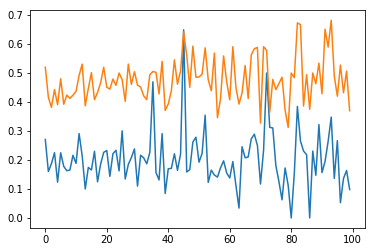

In [87]:
import matplotlib.pyplot as plt

plt.plot(counts_ratio[:,0])
plt.plot(counts_ratio[:,1])
plt.show()

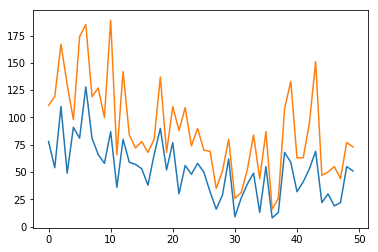

In [91]:
plt.plot((common_counts + other_counts)[50:,0])
plt.plot((common_counts + other_counts)[50:,1])
plt.show()

In [80]:
for i in range(BUCKETS):
    print(MAX_RANK // BUCKETS * (i+1), *single_counts[i], *counts_ratio[i])

1000 2402 3469 0.27073822034628303 0.5202510736703007
2000 901 892 0.1598639455782313 0.41627906976744183
3000 978 1125 0.18734015345268543 0.3815484469170144
4000 559 641 0.22506082725060828 0.44302788844621516
5000 490 441 0.12336719883889695 0.3905635648754915
6000 447 425 0.22477064220183487 0.48009367681498827
7000 488 477 0.17787742899850523 0.39215686274509803
8000 402 366 0.16302186878727634 0.423963133640553
9000 248 343 0.1650485436893204 0.41235392320534225
10000 401 430 0.21626617375231053 0.42357512953367876
11000 301 308 0.18829516539440203 0.43672014260249553
12000 292 296 0.2909930715935335 0.49188311688311687
13000 286 262 0.21391752577319587 0.5306479859894921
14000 140 140 0.1 0.3869565217391304
15000 212 218 0.17424242424242425 0.4469135802469136
16000 314 175 0.16541353383458646 0.5013927576601671
17000 238 263 0.23006134969325154 0.40789473684210525
18000 186 139 0.12442396313364056 0.4330708661417323
19000 146 136 0.18579234972677597 0.4669260700389105
20000 142 

In [63]:
fasttext_model = gensim.models.wrappers.FastText.load_fasttext_format(EMBEDDINGS_PATH)

2018-09-14 09:56:38.98 WARNING in 'gensim.models.word2vec'['word2vec'] at line 466: Slow version of gensim.models.word2vec is being used
2018-09-14 09:56:38.99 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 149: {'kw': {}, 'mode': 'rb', 'uri': '/home/alexeysorokin/data/Data/Fasttext/cc.ru.300.bin'}
2018-09-14 09:56:38.100 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 621: encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'rb', 'fileobj': <_io.BufferedReader name='/home/alexeysorokin/data/Data/Fasttext/cc.ru.300.bin'>}
2018-09-14 09:56:38.100 INFO in 'gensim.models.wrappers.fasttext'['fasttext'] at line 290: loading 2000000 words for fastText model from /home/alexeysorokin/data/Data/Fasttext/cc.ru.300.bin
2018-09-14 09:57:23.545 INFO in 'gensim.models.wrappers.fasttext'['fasttext'] at line 381: loading weights for 2000000 words for fastText model from /home/alexeysorokin/data/Data/Fasttext/cc.ru.300.bin
2018-09-14 09:58:05.224 INFO in 'gen

In [71]:
first = fasttext_model["должник"]
second = fasttext_model["неплательщик"]
print("{:.3f}".format(cosine(first, second)))
for elem in fasttext_model.most_similar_cosmul("должник", topn=30):
    print(elem)

0.517
('Должник', 0.8351151347160339)
('организация-должник', 0.8350762724876404)
('должником', 0.8299497961997986)
('должника', 0.8200226426124573)
('должники', 0.8194742798805237)
('должнику', 0.8186042904853821)
('должница', 0.80782550573349)
('кредитор', 0.8065323233604431)
('взыскатель', 0.7908321022987366)
('должницы', 0.7880319952964783)
('заемщик', 0.7835484147071838)
('заёмщик', 0.7788195610046387)
('должников', 0.7715784907341003)
('должнике', 0.7611795663833618)
('Кредитор', 0.7607552409172058)
('супружник', 0.759833574295044)
('ответчик', 0.7594777345657349)
('заимодавец', 0.7575688362121582)
('должницей', 0.7548431158065796)
('дебитор', 0.7542062997817993)
('должниками', 0.7535617351531982)
('должникам', 0.7515959739685059)
('должнице', 0.7506731152534485)
('займодавец', 0.7499682903289795)
('поручитель', 0.7485876083374023)
('организации-должника', 0.7469428181648254)
('должника-организации', 0.7464943528175354)
('истец', 0.7432489991188049)
('арбитражник', 0.743100404739

In [53]:
SKIPGRAM_EMBEDDINGS_PATH = "/home/alexeysorokin/data/Data/RusVectores/taiga_upos_skipgram_300_2_2018.vec"
gensim_model = gensim.models.Word2Vec.load(SKIPGRAM_EMBEDDINGS_PATH)

2018-09-14 09:47:40.502 INFO in 'gensim.utils'['utils'] at line 272: loading Word2Vec object from /home/alexeysorokin/data/Data/RusVectores/taiga_upos_skipgram_300_2_2018.vec
2018-09-14 09:47:40.502 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 149: {'kw': {}, 'mode': 'rb', 'uri': '/home/alexeysorokin/data/Data/RusVectores/taiga_upos_skipgram_300_2_2018.vec'}
2018-09-14 09:47:40.503 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 621: encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'rb', 'fileobj': <_io.BufferedReader name='/home/alexeysorokin/data/Data/RusVectores/taiga_upos_skipgram_300_2_2018.vec'>}


UnpicklingError: unpickling stack underflow

In [58]:
first = gensim_model["дом_NOUN"]
second = gensim_model["особняк_NOUN"]
print("{:.3f}".format(cosine(first, second)))
print(gensim_model.most_similar_cosmul("дом_NOUN"))

0.310
[('дома_NOUN', 0.8834571838378906), ('особняк_NOUN', 0.8452218770980835), ('домя_NOUN', 0.8436459302902222), ('коттедж_NOUN', 0.8341559171676636), ('домечание_NOUN', 0.8270166516304016), ('до-м_NOUN', 0.8236799836158752), ('квартира_NOUN', 0.8212136626243591), ('дома_ADV', 0.8157405853271484), ('дом_ADV', 0.8122777342796326), ('домик_NOUN', 0.809541642665863)]
